In [42]:
from scipy.fft import fft, ifft
import numpy as np

x = [1,2,3]

y = [0.9,2.1,3]

xf = fft(x)
yf = fft(y)

In [2]:
diff  = np.array(x)-np.array(y)

In [3]:
accuracy = np.sqrt(np.mean(diff**2))

In [4]:
accuracy

0.08164965809277262

In [5]:
xf

array([ 6. -0.j       , -1.5+0.8660254j, -1.5-0.8660254j])

In [6]:
yf

array([ 6.  -0.j        , -1.65+0.77942286j, -1.65-0.77942286j])

In [7]:
accuracy_real = np.sqrt(np.mean((np.real(yf-xf))**2))

In [8]:
accuracy_real

0.12247448713915884

In [9]:
accuracy_imag = np.sqrt(np.mean((np.imag(yf-xf))**2))

In [10]:
accuracy_imag

0.07071067811865482

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


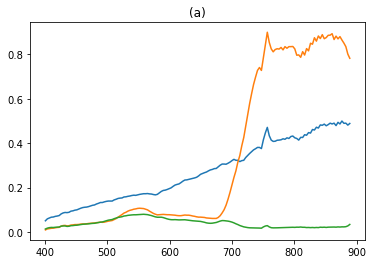

In [12]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
title('(a)')


plt.show()




Text(0.5, 1.0, 'Rock a_map')

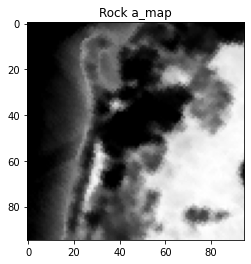

In [13]:
imshow(a_map[:,:,0],cmap=cm.gray)
title('Rock a_map')

In [14]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube, wavelength

In [15]:
hypercube_noiseless,wavelength = create_sythentic_hypercube(a_map, spectra, wavelength)

In [16]:
hypercube_noiseless.shape


(95, 95, 156)

Text(0.5, 1.0, '(a)Real space spectrum')

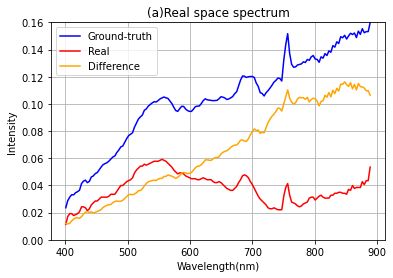

In [77]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength, hypercube_noiseless[20,20,:], 'b', label = 'Ground-truth')
ax.grid()
ax.plot(wavelength, hypercube[20,20,:], 'red', label = 'Real')
ax.plot(wavelength, hypercube_noiseless[20,20,:]-hypercube[20,20,:], 'orange', label = 'Difference')

ax.legend(loc=2)
ax.set_xlabel("Wavelength(nm)")
ax.set_ylabel(r"Intensity")

ax.set_ylim(0, 0.16)

title('(a)Real space spectrum')

In [37]:
xx = hypercube_noiseless[20,20,:].tolist()
yy = hypercube[20,20,:].tolist()

In [38]:
type(xx)

list

In [39]:
diff  = np.array(xx)-np.array(yy)
accuracy = np.sqrt(np.mean(diff**2))

In [40]:
accuracy

0.07346896152981831

In [43]:
X_f = fft(xx)
Y_f = fft(yy)

In [70]:
X_f[1]

(-0.5133805799021289+2.3165337407185618j)

In [ ]:
X_f.shape

In [73]:
def mag_dft (x):
    m = x.shape[0]
    print(m)
    magti = x
    for i in range (m):
        real_x = np.real(x[i])
        imag_x = np.imag(x[i])
        magti[i] = np.sqrt(np.mean(real_x**2+imag_x**2))
    return magti

In [74]:
mag_real = mag_dft (Y_f)
mag_true = mag_dft (X_f)
mag_diff = mag_dft (X_f-Y_f)

156
156
156


In [75]:
mag_diff.shape

(156,)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '(b)DFT space spectrum')

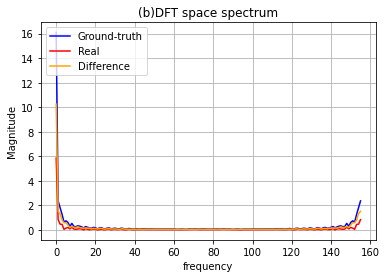

In [81]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mag_true, 'b', label = 'Ground-truth')
ax.grid()
ax.plot(mag_real , 'red', label = 'Real')
ax.plot(mag_diff, 'orange', label = 'Difference')

ax.legend(loc=2)
ax.set_xlabel("frequency")
ax.set_ylabel(r"Magnitude")


title('(b)DFT space spectrum')